In [288]:
from config import settings
from hannover_pylon.data import datamodules as dm
from pathlib import Path
from hannover_pylon.modelling.transformation import FromBuffer , CutPSD , DirectionEncoder,LevelEncoder
import matplotlib.pyplot as plt
from torch import nn 

In [289]:
import numpy as np
freq_axis = np.linspace(0, 825.5, 8197)
db_path = Path(settings.path.processed,'Welch(n_fft=16392, fs=1651, max_freq=825.5).db')


In [290]:
import torch
from torch import nn

class normalize(nn.Module):
    def __init__(self):
        super(normalize, self).__init__()
        
    def forward(self, x):
        return torch.nn.functional.normalize(x, p=2, dim=1)

class PSDClassifierDense(nn.Module):
    def __init__(self, input_size: int, 
                 hidden_layers=[(1024, 0.4), (1024, 0.4), (512, 0.4), (256, 0.4), (128, 0.4), (64, 0.1)],
                 classification_head={'sensor_name': 9, 'sensor_direction': 2},
                 batch_norm=True, 
                 bias=False,
                temperature: float = 1.0):
        super(PSDClassifierDense, self).__init__()
        
        self.input_size = input_size
        self.hidden_layers = [(input_size, 0)] + hidden_layers
        self.classification_head = classification_head
        self.batch_norm = batch_norm
        self.bias = bias
        self.temperature = temperature  # Store temperature parameter

        # Build the encoder and classification heads
        self.encoder = self.build_encoder()
        self.classification_heads = self.build_classification_heads()

    def build_encoder(self):
        layers = []
        if self.batch_norm:
            layers.append(nn.BatchNorm1d(self.input_size))
        
        for i in range(len(self.hidden_layers) - 1):
            in_features = self.hidden_layers[i][0]
            out_features = self.hidden_layers[i + 1][0]
            dropout_rate = self.hidden_layers[i][1]
            
            layers.append(nn.Linear(in_features, out_features, bias=self.bias))
            
            if i < len(self.hidden_layers) - 2:
                if self.batch_norm:
                    layers.append(nn.BatchNorm1d(out_features))
                layers.append(nn.LeakyReLU())
                if dropout_rate > 0:
                    layers.append(nn.Dropout(dropout_rate))
        layers.append(normalize())
        return nn.Sequential(*layers)

    def build_classification_heads(self):
        heads = nn.ModuleDict()
        for key, num_classes in self.classification_head.items():
            heads[key] = nn.Linear(self.hidden_layers[-1][0], num_classes)
        return heads


    def forward(self, x):
        x = self.encoder(x)
        # normalize the output of the encoder
        outputs = {key: head(x) / self.temperature for key, head in self.classification_heads.items()}  # Scale logits by temperature
        return outputs


In [291]:
import pytorch_lightning as pl
from torchmetrics import Accuracy
import torch
import torch.nn as nn

class ClassificationTask(pl.LightningModule):
    def __init__(self, input_size, hidden_layers=[(64, 0), (4, 0)],
                 classification_head= {'level': 9, 'direction': 2},  temperature: float = 1.0):
        super(ClassificationTask, self).__init__()
        
        # Initialize the model
        self.model = PSDClassifierDense(input_size, hidden_layers, classification_head, temperature=temperature)
        
        # Store classification heads and learning rate
        self.classification_head = classification_head

        # Define loss and accuracy for each head
        self.loss = nn.ModuleDict({key: nn.CrossEntropyLoss() for key in classification_head.keys()})
        self.accuracy = nn.ModuleDict({key: Accuracy(task='multiclass',num_classes=val) for key,val in classification_head.items()})
        self.save_hyperparameters()
    def forward(self, x):
        return self.model(x)
    
    def _common_step(self, batch, batch_idx, stage: str):
        x, y = batch['psd'], {key: batch[key] for key in self.classification_head.keys()}
        y_pred = self(x)
        
        total_loss = 0
        for key, target in y.items():
            # Calculate loss
            loss = self.loss[key](y_pred[key], target)
            total_loss += loss

            # Calculate and log metrics
            acc = self.accuracy[key](y_pred[key].argmax(dim=1), target)
            self.log(f'{stage}_{key}_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
            self.log(f'{stage}_{key}_accuracy', acc, on_step=True, on_epoch=True, prog_bar=True)
        self.log(f'{stage}_loss', total_loss, on_step=True, on_epoch=True, prog_bar=True)
            
        return total_loss
    
    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, 'train')
    
    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, 'val')
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


In [292]:
columns = ['psd', 'level','direction']  # Add any other labels you want
transform_func = [nn.Sequential(FromBuffer(),CutPSD(freq_axis=freq_axis,freq_range=(0,150))), LevelEncoder(), DirectionEncoder()]
query_key = f'''
    SELECT id FROM data
    WHERE sensor = "accel"
    AND date BETWEEN "{settings.state.healthy_train.start}" AND "{settings.state.healthy_train.end}"
    AND corrupted = 0
'''
  
data_loader = dm.PSDDataModule(db_path= db_path,
                                 columns=columns,
                                 transform_func=transform_func, 
                                 query_key=query_key, 
                                 batch_size=248, 
                                 return_dict=True, cached=True)


In [293]:
torch.set_float32_matmul_precision('medium')

In [294]:
from pytorch_lightning.callbacks import ModelCheckpoint 
from pytorch_lightning.loggers import MLFlowLogger
mlflow = MLFlowLogger(experiment_name='OOD',
                      log_model=True,
                      save_dir=settings.path.mlflow[1:])
checkpoint_callback = ModelCheckpoint(monitor='val_loss', save_top_k=1, filename='Dense_class-{epoch:02d}-{val_loss:.2f}')

model = ClassificationTask(input_size=1490,temperature = 300,
                           classification_head={'level': 9, 'direction': 2}) 
trainer = pl.Trainer(max_epochs=60, logger=mlflow, callbacks=[checkpoint_callback])
trainer.fit(model, data_loader)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | PSDClassifierDense | 98.8 K | train
1 | loss     | ModuleDict         | 0      | train
2 | accuracy | ModuleDict         | 0      | train
--------------------------------------------------------
98.8 K    Trainable params
0         Non-trainable params
98.8 K    Total params
0.395     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 59: 100%|██████████| 509/509 [00:06<00:00, 76.02it/s, v_num=b17a, train_level_loss_step=2.060, train_level_accuracy_step=0.655, train_direction_loss_step=0.568, train_direction_accuracy_step=1.000, train_loss_step=2.630, val_level_loss_step=2.060, val_level_accuracy_step=0.595, val_direction_loss_step=0.566, val_direction_accuracy_step=1.000, val_loss_step=2.630, val_level_loss_epoch=2.060, val_level_accuracy_epoch=0.664, val_direction_loss_epoch=0.567, val_direction_accuracy_epoch=1.000, val_loss_epoch=2.630, train_level_loss_epoch=2.060, train_level_accuracy_epoch=0.647, train_direction_loss_epoch=0.568, train_direction_accuracy_epoch=1.000, train_loss_epoch=2.630] 

`Trainer.fit` stopped: `max_epochs=60` reached.


Epoch 59: 100%|██████████| 509/509 [00:06<00:00, 75.90it/s, v_num=b17a, train_level_loss_step=2.060, train_level_accuracy_step=0.655, train_direction_loss_step=0.568, train_direction_accuracy_step=1.000, train_loss_step=2.630, val_level_loss_step=2.060, val_level_accuracy_step=0.595, val_direction_loss_step=0.566, val_direction_accuracy_step=1.000, val_loss_step=2.630, val_level_loss_epoch=2.060, val_level_accuracy_epoch=0.664, val_direction_loss_epoch=0.567, val_direction_accuracy_epoch=1.000, val_loss_epoch=2.630, train_level_loss_epoch=2.060, train_level_accuracy_epoch=0.647, train_direction_loss_epoch=0.568, train_direction_accuracy_epoch=1.000, train_loss_epoch=2.630]


In [179]:
model_path= '/home/owilab/Documents/YacineB/Code/hannover-pylon/logs/mlflow/422142011803961963/4727ac261b014e1d9ae4c5521b64d604/checkpoints/Dense_class-epoch=19-val_loss=0.01.ckpt'
model_path = checkpoint_callback.best_model_path
model_path 

'/home/owilab/Documents/YacineB/Code/hannover-pylon/logs/mlflow/422142011803961963/7bf886463a5a41b4916ef4ea3b42169f/checkpoints/Dense_class-epoch=59-val_loss=2.63.ckpt'

In [180]:
model = ClassificationTask.load_from_checkpoint(model_path)

In [213]:
columns = ['psd', 'level','direction']  # Add any other labels you want
transform_func = [nn.Sequential(FromBuffer(),CutPSD(freq_axis=freq_axis,freq_range=(0,150))), LevelEncoder(), DirectionEncoder()]
query_key = f'''
    SELECT id FROM data
    WHERE sensor = "accel"
    AND date BETWEEN "{settings.state.healthy_train.start}" AND "{settings.state.healthy_train.end}"
    AND corrupted = 0
'''
  
data_loader = dm.PSDDataModule(db_path= db_path,
                                 columns=columns,
                                 transform_func=transform_func, 
                                 query_key=query_key, 
                                 batch_size=248, 
                                 return_dict=True, cached=True)
data_loader.setup()

Epoch 0:   0%|          | 0/509 [08:23<?, ?it/s]


In [268]:
# Update columns and transform_func to include 'level' or other labels
model.eval()


embeddings = []
level_labels = []
direction_labels = []
for batch in data_loader.val_dataloader():
    x = batch['psd'].to(model.device)
    embeddings.append(model.model.encoder(x).cpu().detach().numpy())
    level_labels.append(batch['level'].numpy())
    direction_labels.append(batch['direction'].numpy())
    
embeddings = np.concatenate(embeddings, axis=0)
level_labels = np.concatenate(level_labels, axis=0)
direction_labels = np.concatenate(direction_labels, axis=0)

In [269]:
import umap
reducer = umap.UMAP()
embedding_umap = reducer.fit_transform(embeddings)

/tmp/ipykernel_3093250/4222603115.py:22: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.scatterplot(
/tmp/ipykernel_3093250/4222603115.py:31: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.scatterplot(


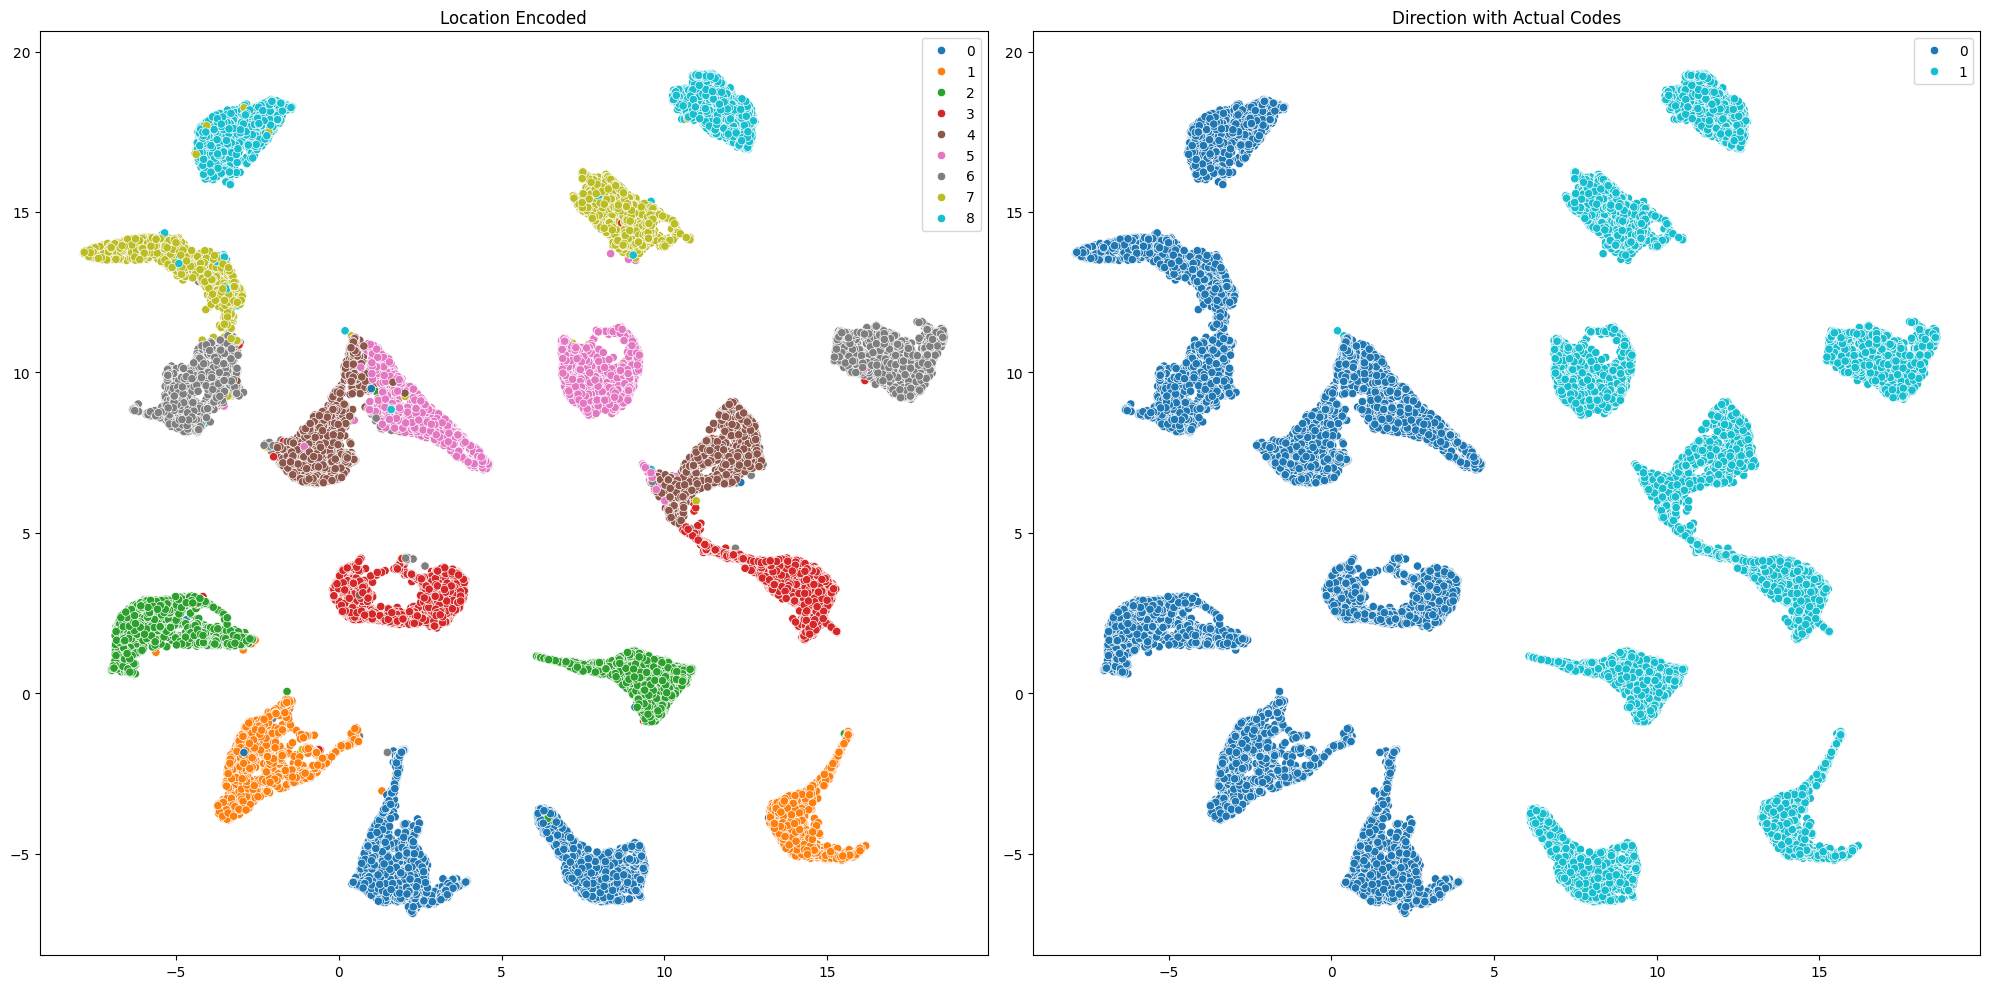

In [270]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns

# Define unique categories for location and direction
unique_locations = np.unique(level_labels)
unique_directions = np.unique(direction_labels)

# Use a predefined colormap from matplotlib
location_cmap = plt.get_cmap('tab10', len(unique_locations))  # tab10 for location categories
direction_cmap = plt.get_cmap('tab10', len(unique_directions))  # Blues for direction categories

# Encode categorical variables into numeric values
location_encoded = LabelEncoder().fit_transform(level_labels)
direction_encoded = LabelEncoder().fit_transform(direction_labels)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot location-encoded scatter plot
sns.scatterplot(
    x=embedding_umap[:, 0],
    y=embedding_umap[:, 1],
    hue=location_encoded,
    palette=location_cmap.colors,
    ax=ax[0],
)

# Plot direction-encoded scatter plot, with actual labels in the legend
sns.scatterplot(
    x=embedding_umap[:, 0],
    y=embedding_umap[:, 1],
    hue=direction_labels,  # Use the actual direction values instead of encoded ones
    hue_order=np.unique(direction_labels),  # Ensure the order is the same as in the data
    palette=direction_cmap.colors,
    ax=ax[1],
)

# Set titles for the subplots
ax[0].set_title('Location Encoded')
ax[1].set_title('Direction with Actual Codes')

plt.tight_layout()
plt.show()


In [271]:
class DataLoaderWrapper:
    def __init__(self, dataloader, device='cuda'):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        for batch in self.dataloader:
            # Assuming your current dataloader returns more than 2 items
            # and you want to keep just the first two (typically features and labels)
            level = batch['level']
            direction = batch['direction']
            # turbine_name and direction are torch tensors of shape (batch_size,) and we need to add them together turbine_name*9 + direction
            label = level*2 + direction
            yield batch['psd'].to(self.device), label
            
    def load_all_data(self):
        x, y = [], []
        
        for batch in self:
            x.append(batch[0])   
            y.append(batch[1])

        return (torch.cat(x), torch.cat(y)) 
    


In [272]:
import numpy as np
from typing import TypeVar, Optional
from sklearn.covariance import OAS
from torch import nn, Tensor
from torch.utils.data import DataLoader

Self = TypeVar('Self')

class DetectorMD(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.device = next(model.parameters()).device
        self.centroids = dict()
        self.max_distance = dict()
        self.min_distance = dict()
        
    def fit(self: Self, data_loader: DataLoader) -> Self:
        z , y = [], []
        for batch in data_loader:
            x, label = batch
            z.append(self.model(x.to(self.device)).cpu().detach())
            y.append(label)
        z  = torch.cat(z).cpu().detach().numpy()
        y = torch.cat(y).cpu().detach().numpy()
        print(z.shape)
        
        return self.fit_features(z, y)
    
    def fit_features(self, z: Tensor, y: Tensor) -> Self:
        for label in np.unique(y):
            idx = y == label
            self.centroids[label] = OAS().fit(z[idx])
            distance_train = self.centroids[label].mahalanobis(z[idx])
            self.max_distance[label] = np.max(distance_train)
            self.min_distance[label] = np.min(distance_train)
        return self
    
    def forward_with_labels(self, x: Tensor, y: Tensor) -> Tensor:
        z = self.model(x)
        z = z.view(z.size(0), -1)
        z = z.cpu().detach().numpy()
        y = y.cpu().detach().numpy()

        scores, indices = [], []
        for y_case in np.unique(y):
            idx = y == y_case
            resultat = self.centroids[y_case].mahalanobis(z[idx])
            # Normalize result to [0, 1] based on min and max distances
            resultat = (resultat - self.min_distance[y_case]) / (self.max_distance[y_case] - self.min_distance[y_case])
            scores.extend(resultat)
            indices.extend(idx)
        
        # Sort scores based on the original indices
        sorted_scores_and_indices = sorted(zip(scores, indices), key=lambda x: x[1])
        scores, indices = zip(*sorted_scores_and_indices)
        
        return torch.tensor(scores, device=self.device)
    
    def forward(self, x: Tensor, y: Optional[Tensor] = None) -> Tensor:
        x = x.to(self.device)
        if y is not None:
            return self.forward_with_labels(x, y)
        else:
            # If `y` is None, handle the forward pass as needed (e.g., predict without labels)
            raise ValueError("`y` is required for labeled forward pass.")


In [273]:
data_loader_wrapped = DataLoaderWrapper(data_loader.train_dataloader())
detector = DetectorMD(model.model.encoder).fit(data_loader_wrapped)

(126129, 16)


In [276]:
detector.centroids

{np.float32(2.0): OAS(),
 np.float32(3.0): OAS(),
 np.float32(4.0): OAS(),
 np.float32(5.0): OAS(),
 np.float32(6.0): OAS(),
 np.float32(7.0): OAS(),
 np.float32(8.0): OAS(),
 np.float32(9.0): OAS(),
 np.float32(10.0): OAS(),
 np.float32(11.0): OAS(),
 np.float32(12.0): OAS(),
 np.float32(13.0): OAS(),
 np.float32(14.0): OAS(),
 np.float32(15.0): OAS(),
 np.float32(16.0): OAS(),
 np.float32(17.0): OAS(),
 np.float32(18.0): OAS(),
 np.float32(19.0): OAS()}

In [ ]:
import pandas as pd
db_path = Path(settings.path.processed,'Welch(n_fft=16392, fs=1651, max_freq=825.5).db')
columns= ['psd','date','level','direction']
transform_func = transform_func = [nn.Sequential(FromBuffer(),CutPSD(freq_axis=freq_axis,freq_range=(0,150))),nn.Identity(), 
                                   LevelEncoder(), DirectionEncoder()]

query_key = f'''
    SELECT id FROM data
    WHERE sensor = "accel"
    AND corrupted = 0
'''
data_loader_eval = dm.PSDDataModule(db_path= db_path,columns=columns,transform_func=transform_func, query_key=query_key, batch_size=5000, return_dict=True, cached=False)
data_loader_eval.setup()

df_res = pd.DataFrame(columns=['date', 'md', 'direction', 'level'])

for batch in data_loader_eval.all_dataloader():
    psds, dates, levels, directions = batch['psd'], batch['date'], batch['level'], batch['direction']
    label = levels*2 + directions
    md = detector(psds, label)
    md = md.cpu().detach().numpy()
    df_temp = pd.DataFrame({'date': dates, 'md': md, 'direction': directions, 'level': levels})
    df_res = pd.concat([df_res, df_temp], axis=0)    

/tmp/ipykernel_3093250/482437609.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_res = pd.concat([df_res, df_temp], axis=0)


In [278]:
events = settings.state

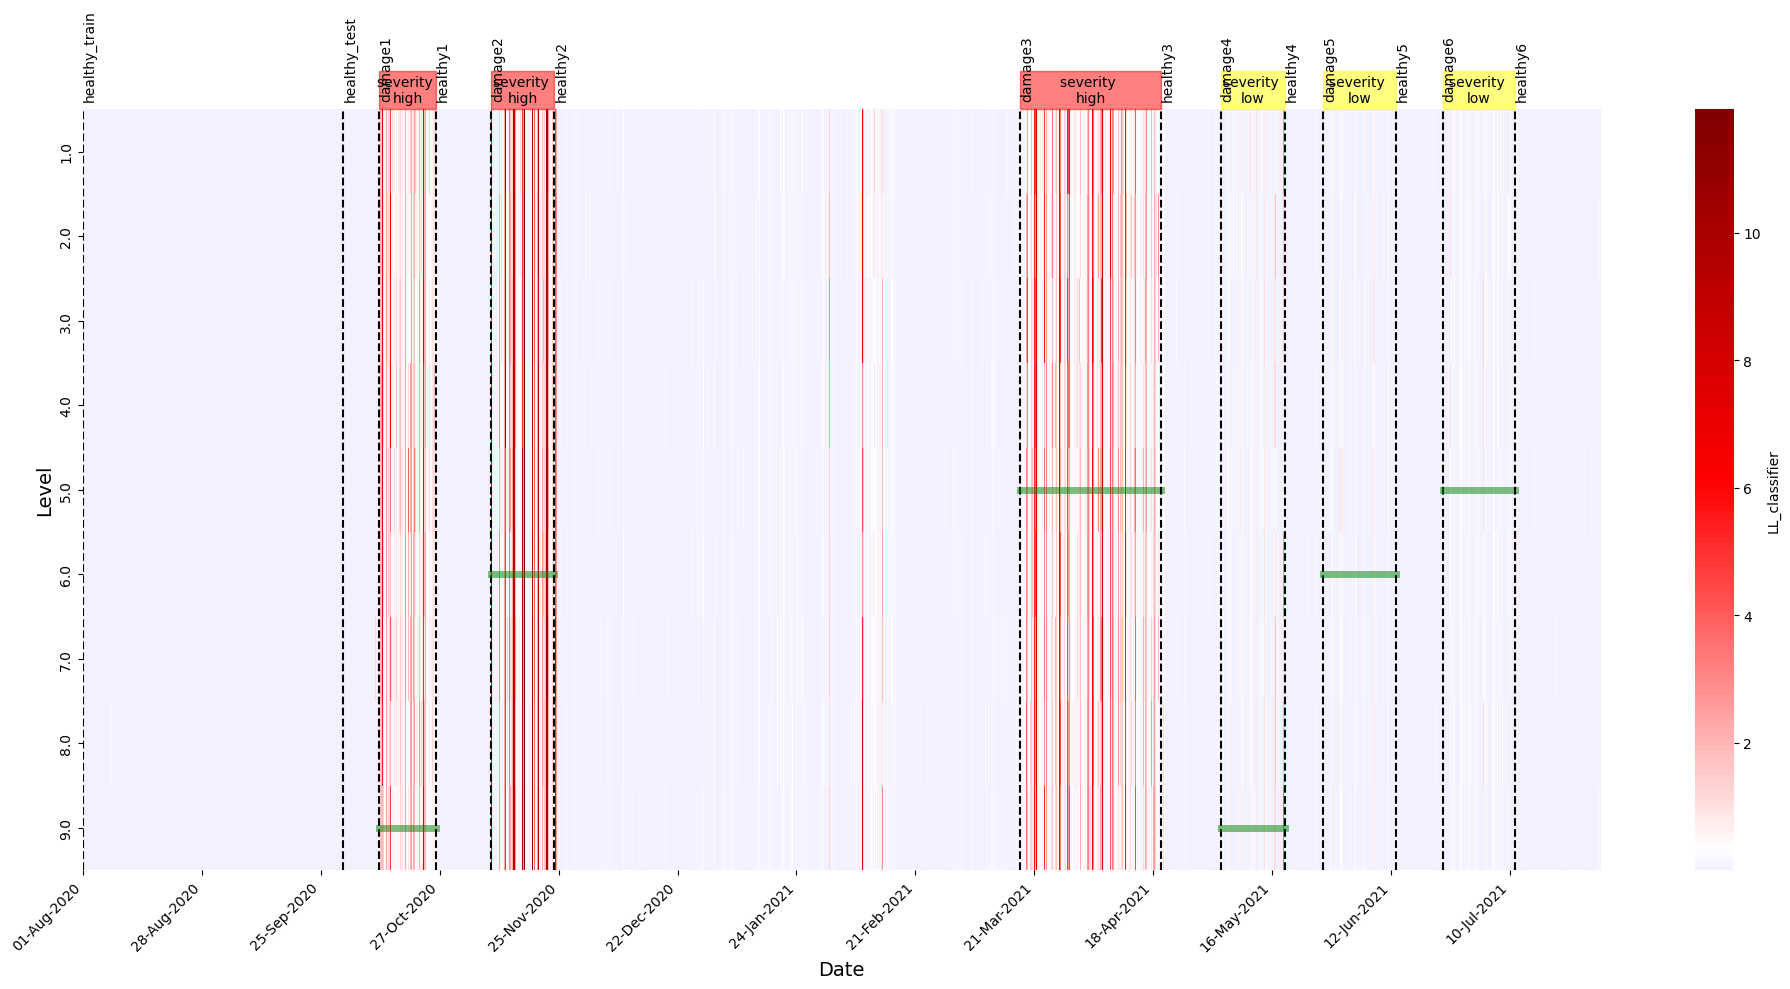

In [280]:
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.patches import Rectangle
import pandas as pd
import numpy as np
from functools import partial
def create_date_formatter(column_dates):
    """Return a custom formatter function for datetime labels."""
    def custom_date_format(x, pos=None):
        if 0 <= int(x) < len(column_dates):
            return column_dates[int(x)].strftime('%d-%b-%Y')
        return ''  # Return empty string if out of range
    return FuncFormatter(custom_date_format)

# Apply the custom date formatter



# Filter the dataframe for 'y' direction and pivot the data for the heatmap
df_res['date'] = pd.to_datetime(df_res['date'])
df_res_y = df_res[df_res['direction'] == 0]
df_pivot = df_res_y.pivot_table(index='level', columns=['date'], values='md', aggfunc='mean')
# average the mse over 1hours rolling window with 1 hour step

df_pivot = df_pivot.T.rolling('1h', min_periods=1).median().T# Create the heatmap plot
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

# Plot the heatmap with seaborn
df_pivot.columns = pd.to_datetime(df_pivot.columns)

sns.heatmap(
    df_pivot, 
    cmap='seismic',  # Set the color map to 'seismic' for highlighting extremes
    cbar_kws={'label': 'LL_classifier'},  # Add a color bar label
    ax=ax,
    center=0.3    
)
# Set axis labels and title
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Level', fontsize=14)
ax.xaxis.set_major_formatter(create_date_formatter(df_pivot.columns))
ax.xaxis.set_major_locator(MaxNLocator(nbins=15))  # Set the maximum number of ticks

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

for event_i in events:
    start = pd.to_datetime(events[event_i]['start'])
    end = pd.to_datetime(events[event_i]['end'])
    idx_start = np.cumsum(df_pivot.columns < start)[-1]
    idx_end = np.cumsum(df_pivot.columns < end)[-1]
    
    # Draw vertical line and label for event
    ax.axvline(idx_start, color='black', linestyle='--', label=f'{event_i} start')
    ax.text(idx_start, -0.1, f'{event_i}', rotation=90, va='bottom', ha='left')
    
    # Draw horizontal line for the closest sensor level during the event
    level = events[event_i].get('closest_sensor', None)
    if level is not None:
        ax.axhline(level - 0.5, xmin=idx_start / len(df_pivot.columns), xmax=idx_end / len(df_pivot.columns), 
                   color='green', linestyle='-', lw=5, alpha=0.5)
    
    # Draw a box above the plot to indicate severity
    severity = events[event_i].get('severity', None)
    if severity is not None:
        color = 'red' if severity == 'high' else 'yellow'
        # Add rectangle patch above the plot to indicate severity
        box_height = 0.05  # Height of the box
        ax.add_patch(Rectangle(
            (idx_start, 1),  # Starting point of the box (above the plot)
            width=idx_end - idx_start,                # Width of the box
            height=box_height,                        # Height of the box
            color=color, 
            alpha=0.5,
            transform=ax.get_xaxis_transform(),       # Transform to place above the x-axis
            clip_on=False                             # Make sure the rectangle is not clipped
        ))
        ax.text((idx_start + idx_end) / 2, -0.1+ box_height, 'severity \n'+severity, ha='center', va='bottom', color='black')
# Tighten the layout
plt.tight_layout()
plt.savefig('ControlChart_AE_PSD_version_1.png')

# Show the plot
plt.show()


In [281]:
from hannover_pylon.evaluation.utils import label_dataframe_event, compute_TPR, auc_computation

In [282]:
df_res['label']=label_dataframe_event(df_res['date'],events)

/home/owilab/Documents/YacineB/Code/hannover-pylon/hannover_pylon/evaluation/utils.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'healthy_train' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  labels.loc[mask] = event_name


In [283]:
df_row = df_res.query('direction == 1 & level == 7')
threshold = df_row.query('label == "healthy_train"')['md'].quantile(0.999)
df_row.groupby(['label']).apply(lambda x: compute_TPR(x['md'].values, threshold))

/tmp/ipykernel_3093250/1948658867.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_row.groupby(['label']).apply(lambda x: compute_TPR(x['md'].values, threshold))


label
damage1          0.584945
damage2          0.437002
damage3          0.482686
damage4          0.132128
damage5          0.079508
damage6          0.073011
healthy1         0.033550
healthy2         0.041754
healthy3         0.034757
healthy4         0.005405
healthy5         0.018436
healthy6         0.014593
healthy_test     0.020816
healthy_train    0.001028
dtype: float64

In [284]:
df_res['label']=label_dataframe_event(df_res['date'],events)

/home/owilab/Documents/YacineB/Code/hannover-pylon/hannover_pylon/evaluation/utils.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'healthy_train' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  labels.loc[mask] = event_name


In [285]:
df_pivot = df_res.pivot_table(index='date',
                              columns=['direction', 'level'],
                              values='md').reset_index()

# Flatten the MultiIndex columns
df_pivot.columns = [
    '_'.join([str(col) for col in column if col != 'date']) if column != 'date' else 'date'
    for column in df_pivot.columns
]


df_pivot.rename(columns={'': 'date'}, inplace=True)
df_pivot['label'] = label_dataframe_event(df_pivot['date'], events)

/home/owilab/Documents/YacineB/Code/hannover-pylon/hannover_pylon/evaluation/utils.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'healthy_train' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  labels.loc[mask] = event_name


In [286]:
from sklearn.covariance import OAS
md = OAS()
md= md.fit(df_pivot.query('label == "healthy_train"').filter(regex='[1-9]_[1-9]'))
df_pivot['mahalanobis'] = md.mahalanobis(df_pivot.filter(regex='[1-9]_[1-9]'))

In [287]:


threshold = df_pivot.query('label == "healthy_train"')['mahalanobis'].quantile(0.999)
df_pivot.groupby(['label']).apply(lambda x: compute_TPR(x['mahalanobis'].values, threshold))

/tmp/ipykernel_3093250/3846486056.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_pivot.groupby(['label']).apply(lambda x: compute_TPR(x['mahalanobis'].values, threshold))


label
damage1          0.714062
damage2          0.504450
damage3          0.590372
damage4          0.177561
damage5          0.127459
damage6          0.143560
healthy1         0.050325
healthy2         0.063653
healthy3         0.055611
healthy4         0.016988
healthy5         0.051494
healthy6         0.023280
healthy_test     0.029142
healthy_train    0.001028
dtype: float64

In [234]:
min_md, max_md = df_pivot.query('label == "healthy_train"')['mahalanobis'].quantile(0.001), df_pivot.query('label == "healthy_train"')['mahalanobis'].quantile(0.999)
df_pivot['mahalanobis'] = (df_pivot['mahalanobis'] - min_md) / (max_md - min_md)
df_pivot['group_label'] = df_pivot['label'].apply(lambda x: 'healthy' if x.startswith('healthy') else x)
score = df_pivot.groupby(['label']).apply(lambda x: np.median(x['mahalanobis'].values)) 
score = score / score['healthy_train']
order_of_states = list(settings.state.to_dict().keys())
# reorder the score according to the order of the states
score = score.loc[order_of_states]
score

/tmp/ipykernel_3093250/4047320511.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  score = df_pivot.groupby(['label']).apply(lambda x: np.median(x['mahalanobis'].values))


label
healthy_train        1.000000
healthy_test         0.863376
damage1          50687.402453
healthy1            14.751665
damage2          28877.031159
healthy2           245.047805
damage3          18620.147628
healthy3           148.461698
damage4            544.989370
healthy4            89.999431
damage5            709.044839
healthy5            90.919707
damage6           1209.471760
healthy6            60.987224
dtype: float64

In [235]:
ratio = score.pct_change()
ratio

label
healthy_train             NaN
healthy_test        -0.136624
damage1          58707.387872
healthy1            -0.999709
damage2           1956.543890
healthy2            -0.991514
damage3             74.985776
healthy3            -0.992027
damage4              2.670909
healthy4            -0.834860
damage5              6.878326
healthy5            -0.871772
damage6             12.302636
healthy6            -0.949575
dtype: float64

(1e-06, 1000000.0)

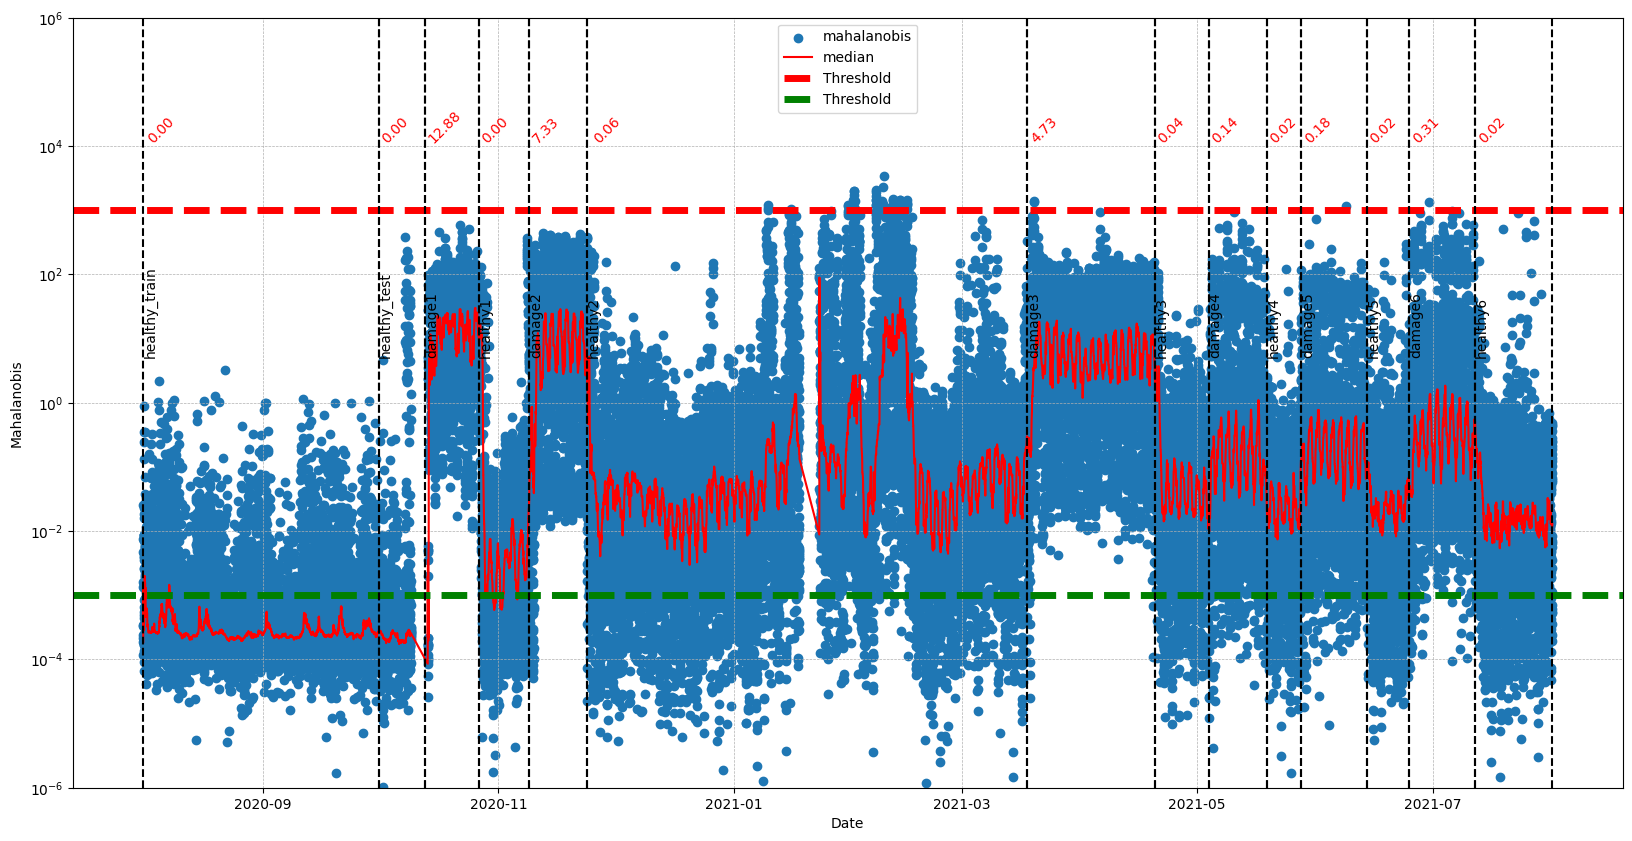

In [236]:
fig , ax = plt.subplots(1,1,figsize=(20,10))
df_pivot['date'] = pd.to_datetime(df_pivot['date'])
df_pivot.index = df_pivot['date']
ax.scatter(df_pivot['date'],df_pivot['mahalanobis'],label='mahalanobis')
# plot a moving average of the mahalanobis score 
ax.plot(df_pivot['date'],df_pivot['mahalanobis'].rolling('1D').median(),label='median',color='red')
ax.axhline(threshold, color='red', linestyle='--', label='Threshold',lw=5)
ax.axhline(1e-3, color='green', linestyle='--', label='Threshold',lw=5)
ax.set_xlabel('Date')
ax.set_ylabel('Mahalanobis')
ax.legend()
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.set_yscale('log')
for event_i in events:
    start = pd.to_datetime(events[event_i]['start'])
    end = pd.to_datetime(events[event_i]['end'])
    ax.axvline(start, color='black', linestyle='--', label=f'{event_i} start')
    ax.axvline(end, color='black', linestyle='--', label=f'{event_i} end')
    ax.text(start, 5, f'{event_i}', rotation=90, va='bottom', ha='left')
    # compute the mean of the mahalanobis score during the event
    mask = (df_pivot['date'] >= start) & (df_pivot['date'] <= end)
    mid_point = (end - start) / 100 + start 
    mean = df_pivot.loc[mask, 'mahalanobis'].median()
    ax.text(mid_point, 10000, f'{mean:.2f}', rotation=45, va='bottom', ha='left', color='red') 
ax.set_ylim(1e-6,1e6)

# add Mixup augmentation :

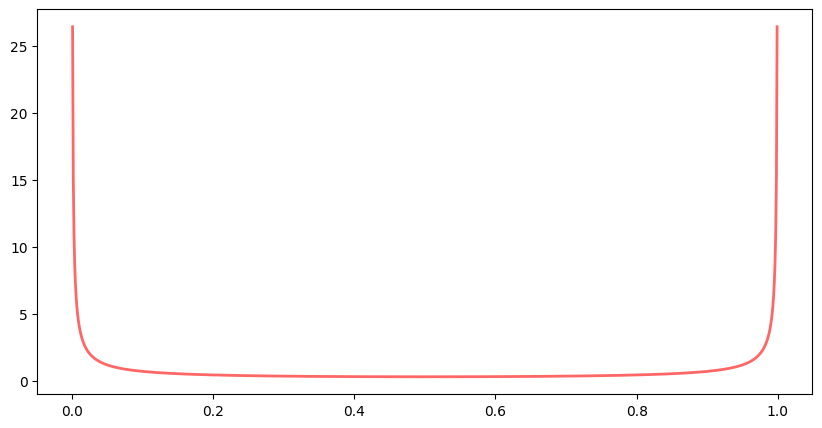

In [101]:
# let's plot beta disitrubtion
from scipy.stats import beta

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Define the parameters for the beta distribution
a= 0.2
x = np.linspace(0, 1, 1000)

# Plot the beta distribution
ax.plot(x, beta.pdf(x, a, a), 'r-', lw=2, alpha=0.6, label='beta pdf')


In [237]:
import torch
import numpy as np

def mixup_data(x, y_dict, alpha=1.0):
    '''Compute MixUp data for multiple labels.'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    mixed_y = {}

    for key in y_dict.keys():
        y_a = y_dict[key]
        y_b = y_dict[key][index]
        num_classes = y_a.max().item() + 1  # Assuming classes are 0-indexed
        # Convert labels to one-hot encoding
        y_a_one_hot = torch.nn.functional.one_hot(y_a, num_classes=num_classes).float()
        y_b_one_hot = torch.nn.functional.one_hot(y_b, num_classes=num_classes).float()
        # Mix labels
        mixed_y[key] = lam * y_a_one_hot + (1 - lam) * y_b_one_hot

    return mixed_x, mixed_y


In [240]:
import pytorch_lightning as pl
from torchmetrics import Accuracy
import torch
import torch.nn as nn
import torch.nn.functional as F

class ClassificationTask(pl.LightningModule):
    def __init__(self, input_size, hidden_layers=[(128, 0), (16, 0)],
                 classification_head={'level': 9, 'direction': 2}, temperature: float = 1.0):
        super(ClassificationTask, self).__init__()
        
        # Initialize the model
        self.model = PSDClassifierDense(input_size, hidden_layers, classification_head, temperature=temperature)
        
        # Store classification heads and learning rate
        self.classification_head = classification_head

        # Define loss and accuracy for each head
        # Use KLDivLoss for handling soft labels resulting from MixUp during training
        self.loss_train = nn.ModuleDict({key: nn.CrossEntropyLoss() for key in classification_head.keys()})
        # Use CrossEntropyLoss for validation
        self.loss_val = nn.ModuleDict({key: nn.CrossEntropyLoss() for key in classification_head.keys()})
        self.accuracy = nn.ModuleDict({
            key: Accuracy(task='multiclass', num_classes=val) for key, val in classification_head.items()
        })
        self.save_hyperparameters()
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x = batch['psd']
        y_dict = {key: batch[key] for key in self.classification_head.keys()}
        
        # Apply MixUp augmentation
        x_mixed, y_mixed = mixup_data(x, y_dict, alpha=5)
        
        y_pred = self(x_mixed)
        
        total_loss = 0
        for key in self.classification_head.keys():
            logits = y_pred[key]
            target = y_mixed[key]
            
            # Compute KL divergence loss
            loss = self.loss_train[key](logits, target)
            total_loss += loss

            # Optionally log training loss (accuracy might not be meaningful due to label mixing)
            self.log(f'train_{key}_loss', loss, on_step=True, on_epoch=True, prog_bar=True)

        self.log('train_loss', total_loss, on_step=True, on_epoch=True, prog_bar=True)
        return total_loss
    
    def validation_step(self, batch, batch_idx):
        x = batch['psd']
        y = {key: batch[key] for key in self.classification_head.keys()}
        y_pred = self(x)
        
        total_loss = 0
        for key in self.classification_head.keys():
            logits = y_pred[key]
            target = y[key]
            
            # Compute CrossEntropyLoss for validation
            loss = self.loss_val[key](logits, target)
            total_loss += loss

            # Compute and log accuracy
            acc = self.accuracy[key](logits.argmax(dim=1), target)
            self.log(f'val_{key}_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
            self.log(f'val_{key}_accuracy', acc, on_step=False, on_epoch=True, prog_bar=True)
        
        self.log('val_loss', total_loss, on_step=False, on_epoch=True, prog_bar=True)
        return total_loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


In [241]:
model = ClassificationTask(input_size=1490, temperature=300,
                           classification_head={'level': 9, 'direction': 2})
mlflow = MLFlowLogger(experiment_name='OOD',
                        log_model=True,
                        save_dir=settings.path.mlflow[1:])
checkpoint_callback = ModelCheckpoint(monitor='val_loss', save_top_k=1, filename='Dense_class-{epoch:02d}-{val_loss:.2f}')

trainer = pl.Trainer(max_epochs=60, logger=mlflow, callbacks=[checkpoint_callback])
trainer.fit(model, data_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | model      | PSDClassifierDense | 196 K  | train
1 | loss_train | ModuleDict         | 0      | train
2 | loss_val   | ModuleDict         | 0      | train
3 | accuracy   | ModuleDict         | 0      | train
----------------------------------------------------------
196 K     Trainable params
0         Non-trainable params
196 K     Total params
0.785     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Already set
Epoch 59: 100%|██████████| 509/509 [00:05<00:00, 94.70it/s, v_num=ec49, train_level_loss_step=1.970, train_direction_loss_step=0.541, train_loss_step=2.510, val_level_loss=1.920, val_level_accuracy=0.981, val_direction_loss=0.473, val_direction_accuracy=1.000, val_loss=2.390, train_level_loss_epoch=1.990, train_direction_loss_epoch=0.554, train_loss_epoch=2.550] 

`Trainer.fit` stopped: `max_epochs=60` reached.


Epoch 59: 100%|██████████| 509/509 [00:05<00:00, 94.20it/s, v_num=ec49, train_level_loss_step=1.970, train_direction_loss_step=0.541, train_loss_step=2.510, val_level_loss=1.920, val_level_accuracy=0.981, val_direction_loss=0.473, val_direction_accuracy=1.000, val_loss=2.390, train_level_loss_epoch=1.990, train_direction_loss_epoch=0.554, train_loss_epoch=2.550]


# Regression task 

In [255]:
class PSDClassifierDense(nn.Module):
    def __init__(self, input_size: int, 
                 hidden_layers=[(1024, 0.4), (1024, 0.4), (512, 0.4), (256, 0.4), (128, 0.4), (64, 0.1)],
                 classification_head={'direction': 2},
                 regression_head={'level': 1},
                 batch_norm=True, 
                 bias=False,
                 temperature: float = 1.0):
        super(PSDClassifierDense, self).__init__()
        
        self.input_size = input_size
        self.hidden_layers = [(input_size, 0)] + hidden_layers
        self.classification_head = classification_head
        self.regression_head = regression_head
        self.batch_norm = batch_norm
        self.bias = bias
        self.temperature = temperature  # Store temperature parameter

        # Build the encoder and output heads
        self.encoder = self.build_encoder()
        self.classification_heads = self.build_classification_heads()
        self.regression_heads = self.build_regression_heads()

    def build_encoder(self):
        layers = []
        if self.batch_norm:
            layers.append(nn.BatchNorm1d(self.input_size))
        
        for i in range(len(self.hidden_layers) - 1):
            in_features = self.hidden_layers[i][0]
            out_features = self.hidden_layers[i + 1][0]
            dropout_rate = self.hidden_layers[i][1]
            
            layers.append(nn.Linear(in_features, out_features, bias=self.bias))
            
            if i < len(self.hidden_layers) - 2:
                if self.batch_norm:
                    layers.append(nn.BatchNorm1d(out_features))
                layers.append(nn.LeakyReLU())
                if dropout_rate > 0:
                    layers.append(nn.Dropout(dropout_rate))
        layers.append(normalize())
        return nn.Sequential(*layers)

    def build_classification_heads(self):
        heads = nn.ModuleDict()
        for key, num_classes in self.classification_head.items():
            heads[key] = nn.Linear(self.hidden_layers[-1][0], num_classes)
        return heads

    def build_regression_heads(self):
        heads = nn.ModuleDict()
        for key in self.regression_head.keys():
            heads[key] = nn.Linear(self.hidden_layers[-1][0], 1)
        return heads

    def forward(self, x):
        x = self.encoder(x)
        outputs = {}
        # Classification outputs
        for key, head in self.classification_heads.items():
            outputs[key] = head(x) / self.temperature  # Scale logits by temperature
        # Regression outputs
        for key, head in self.regression_heads.items():
            outputs[key] = head(x).squeeze(-1)  # Remove last dimension
        return outputs


In [256]:
import pytorch_lightning as pl
from torchmetrics import Accuracy, MeanSquaredError
import torch
import torch.nn as nn
import torch.nn.functional as F

class ClassificationTask(pl.LightningModule):
    def __init__(self, input_size, hidden_layers=[(128, 0), (16, 0)],
                 classification_head={'direction': 2},
                 regression_head={'level': 1},
                 temperature: float = 1.0):
        super(ClassificationTask, self).__init__()
        
        # Initialize the model
        self.model = PSDClassifierDense(
            input_size, hidden_layers,
            classification_head=classification_head,
            regression_head=regression_head,
            temperature=temperature
        )
        
        # Store heads
        self.classification_head = classification_head
        self.regression_head = regression_head

        # Define loss and accuracy for each head
        # Classification losses
        self.loss_classification = nn.ModuleDict({key: nn.CrossEntropyLoss() for key in classification_head.keys()})
        self.accuracy = nn.ModuleDict({
            key: Accuracy(task='multiclass', num_classes=val) for key, val in classification_head.items()
        })
        # Regression losses
        self.loss_regression = nn.ModuleDict({key: nn.MSELoss() for key in regression_head.keys()})
        self.mse_metric = nn.ModuleDict({key: MeanSquaredError() for key in regression_head.keys()})

        self.save_hyperparameters()
        
    def forward(self, x):
        return self.model(x)
    
    def _common_step(self, batch, batch_idx, stage: str):
        x = batch['psd']
        y = {key: batch[key] for key in self.classification_head.keys()}
        y.update({key: batch[key].float() for key in self.regression_head.keys()})
        y_pred = self(x)
        
        total_loss = 0
        # Classification loss
        for key in self.classification_head.keys():
            logits = y_pred[key]
            target = y[key]
            
            # Compute CrossEntropyLoss
            loss = self.loss_classification[key](logits, target)
            total_loss += loss

            # Compute and log accuracy
            acc = self.accuracy[key](logits.argmax(dim=1), target)
            self.log(f'{stage}_{key}_loss', loss, on_step=(stage=='train'), on_epoch=True, prog_bar=True)
            self.log(f'{stage}_{key}_accuracy', acc, on_step=(stage=='train'), on_epoch=True, prog_bar=True)
        
        # Regression loss
        for key in self.regression_head.keys():
            pred = y_pred[key]
            target = y[key]
            
            # Compute MSE loss
            loss = self.loss_regression[key](pred, target)
            total_loss += loss

            # Compute and log MSE metric
            mse = self.mse_metric[key](pred, target)
            self.log(f'{stage}_{key}_loss', loss, on_step=(stage=='train'), on_epoch=True, prog_bar=True)
            self.log(f'{stage}_{key}_MSE', mse, on_step=(stage=='train'), on_epoch=True, prog_bar=True)

        self.log(f'{stage}_loss', total_loss, on_step=(stage=='train'), on_epoch=True, prog_bar=True)
        return total_loss
    
    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, 'train')
    
    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, 'val')
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


In [265]:
# Update columns and transformations
columns = ['psd', 'level', 'direction']

# Remove LevelEncoder() if it encodes 'level' as classes
# If necessary, normalize 'level' values
class LevelFloat(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def forward(self, level):
        return torch.tensor(level, dtype=torch.float)

transform_func = [
    nn.Sequential(FromBuffer(), CutPSD(freq_axis=freq_axis, freq_range=(0, 150))),
    LevelFloat(),
    DirectionEncoder()
]


In [266]:
query_key = f'''
    SELECT id FROM data
    WHERE sensor = "accel"
    AND date BETWEEN "{settings.state.healthy_train.start}" AND "{settings.state.healthy_train.end}"
    AND corrupted = 0
'''
data_loader = dm.PSDDataModule(
    db_path=db_path,
    columns=columns,
    transform_func=transform_func,
    query_key=query_key,
    batch_size=248,
    return_dict=True,
    cached=True
)


In [267]:
model = ClassificationTask(
    input_size=1490,
    temperature=300,
    classification_head={'direction': 2},
    regression_head={'level': 1}
)

mlflow = MLFlowLogger(
    experiment_name='OOD',
    log_model=True,
    save_dir=settings.path.mlflow[1:]
)
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss', save_top_k=1, filename='Dense_class-{epoch:02d}-{val_loss:.2f}'
)

trainer = pl.Trainer(
    max_epochs=60,
    logger=mlflow,
    callbacks=[checkpoint_callback]
)
trainer.fit(model, data_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 0:   0%|          | 0/509 [17:37:51<?, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | model               | PSDClassifierDense | 196 K  | train
1 | loss_classification | ModuleDict         | 0      | train
2 | accuracy            | ModuleDict         | 0      | train
3 | loss_regression     | ModuleDict         | 0      | train
4 | mse_metric          | ModuleDict         | 0      | train
-------------------------------------------------------------------
196 K     Trainable params
0         Non-trainable params
196 K     Total params
0.784     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Epoch 59: 100%|██████████| 509/509 [00:06<00:00, 80.93it/s, v_num=37ae, train_direction_loss_step=0.412, train_direction_accuracy_step=1.000, train_level_loss_step=0.0753, train_level_MSE_step=0.0753, train_loss_step=0.488, val_direction_loss=0.417, val_direction_accuracy=0.999, val_level_loss=0.0644, val_level_MSE=0.0644, val_loss=0.482, train_direction_loss_epoch=0.420, train_direction_accuracy_epoch=0.999, train_level_loss_epoch=0.0702, train_level_MSE_epoch=0.0702, train_loss_epoch=0.490] 

`Trainer.fit` stopped: `max_epochs=60` reached.


Epoch 59: 100%|██████████| 509/509 [00:06<00:00, 80.61it/s, v_num=37ae, train_direction_loss_step=0.412, train_direction_accuracy_step=1.000, train_level_loss_step=0.0753, train_level_MSE_step=0.0753, train_loss_step=0.488, val_direction_loss=0.417, val_direction_accuracy=0.999, val_level_loss=0.0644, val_level_MSE=0.0644, val_loss=0.482, train_direction_loss_epoch=0.420, train_direction_accuracy_epoch=0.999, train_level_loss_epoch=0.0702, train_level_MSE_epoch=0.0702, train_loss_epoch=0.490]
